In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from math import comb  # Combinations
#from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from itertools import combinations

from utils.ae_torch_classes import *
#from utils.LSTM_gesture_classifier import *

In [18]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [22]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\"
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'
#metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_dir = "EMG_PCA8\\"
both_dir = "Both_PCA40\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

full_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df]).reset_index(drop=True)], axis=1)
full_both_df = pd.concat([metadata_cols_df, pd.concat([both_training_users_df, both_test_users_df]).reset_index(drop=True)], axis=1)

In [23]:
print(full_emg_df.shape)
full_emg_df.head()

(204800, 11)


,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,7
0,P102,pan,1,-1.341323,-0.812209,0.089633,-0.231389,-1.102774,-0.123494,-0.452216,-0.563469
1,P102,pan,1,-0.644262,-0.860011,0.240803,-0.036121,-1.728382,-0.271787,-1.100263,0.143207
2,P102,pan,1,-1.251829,-0.823973,-0.213519,0.139521,-2.368628,-0.276726,-2.114243,0.468320
3,P102,pan,1,-1.494897,-0.633561,-0.233368,0.250943,-2.434067,-0.437012,-2.570415,0.370891
4,P102,pan,1,1.615750,-1.806795,-1.070433,-0.332640,-2.581807,-0.507581,-3.102347,0.600151


In [24]:
print(full_both_df.shape)
full_both_df.head()

(204800, 43)


,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,P102,pan,1,-0.030730,-0.052976,0.176556,-0.048078,-0.390790,-2.119829,0.875118,...,-0.253283,-0.248582,0.283079,-0.178321,-0.087101,-0.027081,0.000970,0.124380,-0.100580,-0.119294
1,P102,pan,1,0.077533,-0.108477,0.128970,-0.032167,-0.182756,-1.604412,0.701500,...,-0.423007,0.097453,0.184025,0.027788,0.112078,-0.414946,-0.210576,0.277156,0.051190,-0.039548
2,P102,pan,1,0.268279,-0.369027,0.268750,0.105239,-0.190292,-2.093812,1.012038,...,-0.311882,0.138655,-0.067485,0.201313,-0.051898,-0.479894,-0.079818,0.398142,0.058779,-0.095208
3,P102,pan,1,-0.106155,-0.291958,0.270681,0.035371,-0.204143,-2.314179,0.801514,...,-0.585487,-0.100021,0.082335,0.042349,-0.179251,-0.106235,-0.034940,0.386797,-0.034177,-0.132103
4,P102,pan,1,0.673338,-0.345606,0.246740,0.238184,0.948365,-0.041183,0.279347,...,-0.262556,0.011353,-0.353489,0.209535,-0.402682,-0.353866,0.106203,0.366540,0.218785,-0.080414


In [25]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

In [34]:
num_users = len(full_emg_df['Participant'].unique())
participant_labels = full_emg_df['Participant'].unique()

full_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [35]:
full_emg_df.columns

Index(['Participant', 'Gesture_ID', 'Gesture_Num', 0, 1, 2, 3, 4, 5, 6, 7], dtype='object')

In [37]:
df = full_emg_df

# Group by 'Participant' to get user-wide datasets (eg, all gestures, all trials)
grouped = df.groupby(['Participant'])
# Extract the submatrices for each gesture
users_submatrices = [group[1].iloc[:, 3:].values for group in grouped]  # Extract EMG columns only


In [38]:
# Step 3: Calculate the pairwise distances between the submatrices
# Define a custom distance function that operates on submatrices
def submatrix_distance(mat1, mat2, metric='euclidean',  norm='fro', method='mean'):
    # metric: cityblock, chebyshev, cosine
    # norm: mean, fro, np.inf
    if method=='both':
        if norm=='fro' or norm==np.inf:
            return np.linalg.norm(cdist(mat1, mat2, metric=metric), norm)
        else:
            raise ValueError(f"norm {norm} not recognized")
    elif method=='norm':
        return np.linalg.norm(mat1 - mat2, norm)
    elif method=='mean':
        return np.mean(cdist(mat1, mat2, metric=metric))
    else:
        raise ValueError(f"method {method} not recognized")

In [39]:
start_time = time.time()
# Create a distance matrix
num_users = len(users_submatrices)
distance_matrix = np.zeros((num_users, num_users))
for i in range(num_users):
    for j in range(i, num_users):
        dist = submatrix_distance(users_submatrices[i], users_submatrices[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist
print(f"Distance matrix completed in {time.time() - start_time}s")

Distance matrix completed in 604.8518273830414s


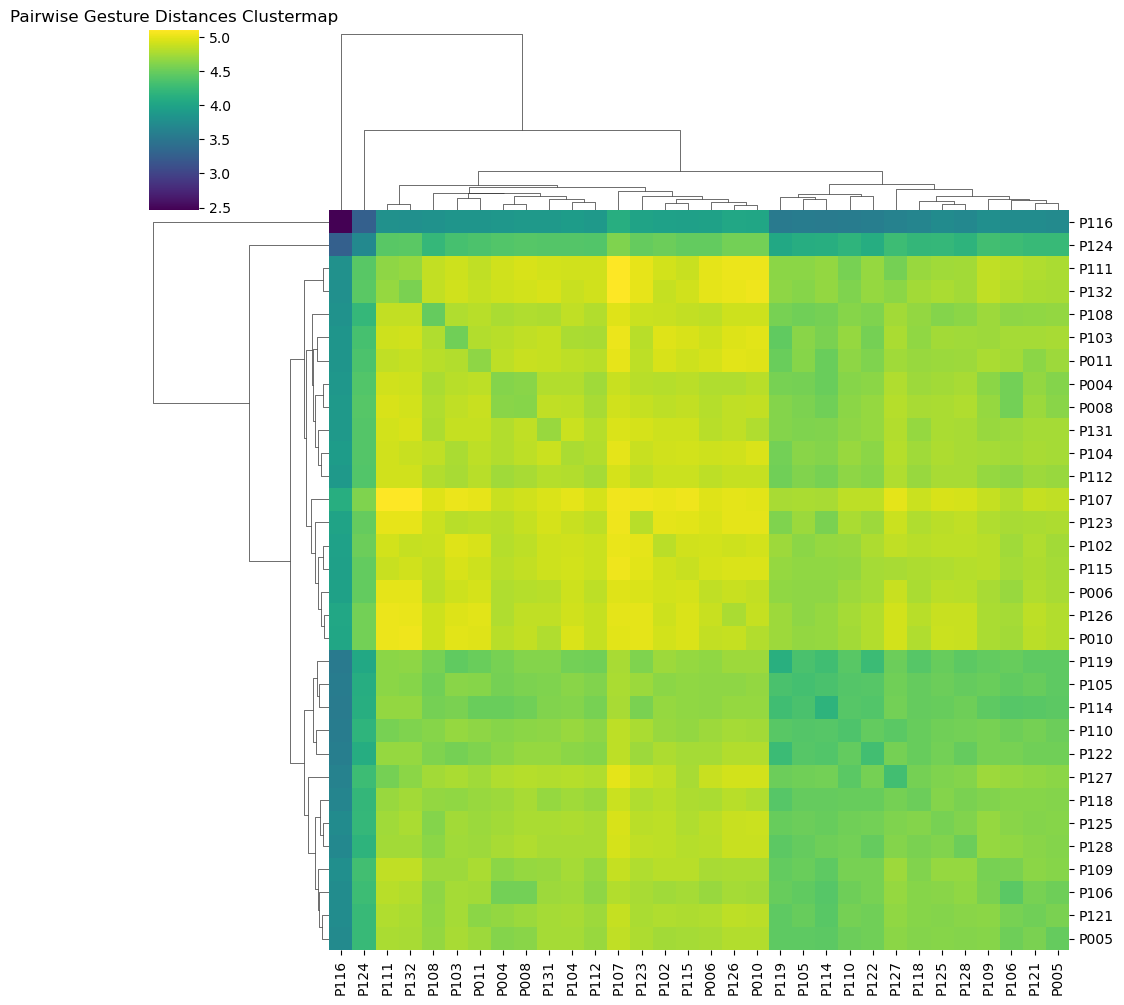

In [40]:
sns.clustermap(distance_matrix, xticklabels=participant_labels, yticklabels=participant_labels, cmap='viridis')
plt.title('Pairwise Gesture Distances Clustermap')
plt.show()

In [41]:
def clustermap_users(users_submatrices, participant_labels, dist_metric='euclidean', dist_norm='fro', dist_method='mean', clsmap_title='Pairwise Gesture Distances Clustermap'):
    start_time = time.time()
    num_users = len(users_submatrices)
    distance_matrix = np.zeros((num_users, num_users))
    for i in range(num_users):
        for j in range(i, num_users):
            dist = submatrix_distance(users_submatrices[i], users_submatrices[j], metric=dist_metric,  norm=dist_norm, method=dist_method)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    print(f"Distance matrix completed in {time.time() - start_time}s")
    
    start_time = time.time()
    clsmap_obj = sns.clustermap(distance_matrix, xticklabels=participant_labels, yticklabels=participant_labels, cmap='viridis')
    plt.title(clsmap_title)
    plt.show()
    print(f"Clustermap completed in {time.time() - start_time}s")
    
    return clsmap_obj, distance_matrix

Distance matrix completed in 545.8927836418152s


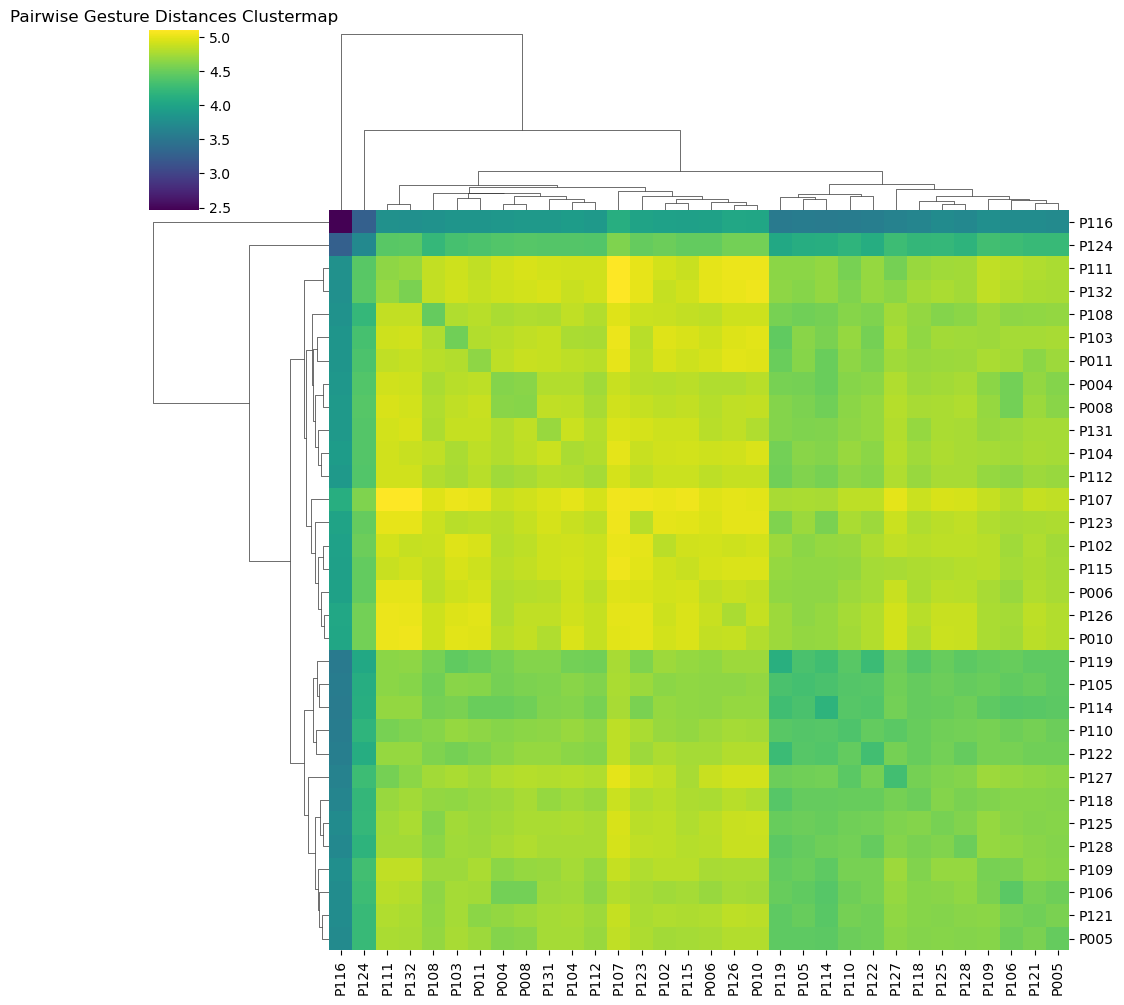

Clustermap completed in 1.1801302433013916s


In [42]:
clsmap_obj0, distance_matrix0 = clustermap_users(users_submatrices, participant_labels, dist_metric='euclidean', dist_norm='fro', dist_method='mean')


Distance matrix completed in 263.1825053691864s


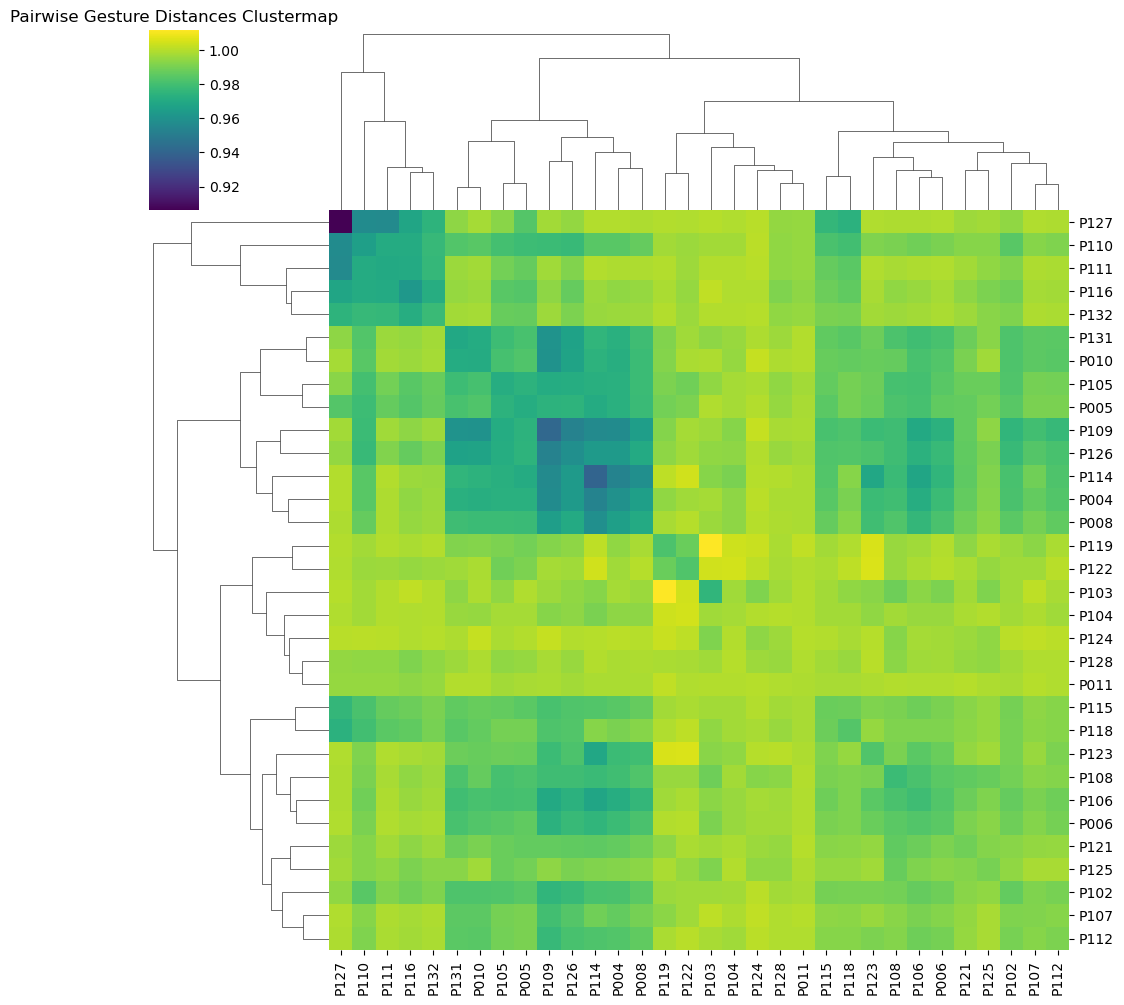

Clustermap completed in 2.640852451324463s


In [43]:
clsmap_obj1, distance_matrix1 = clustermap_users(users_submatrices, participant_labels, dist_metric='cosine', dist_norm='fro', dist_method='mean')


Distance matrix completed in 332.07821249961853s


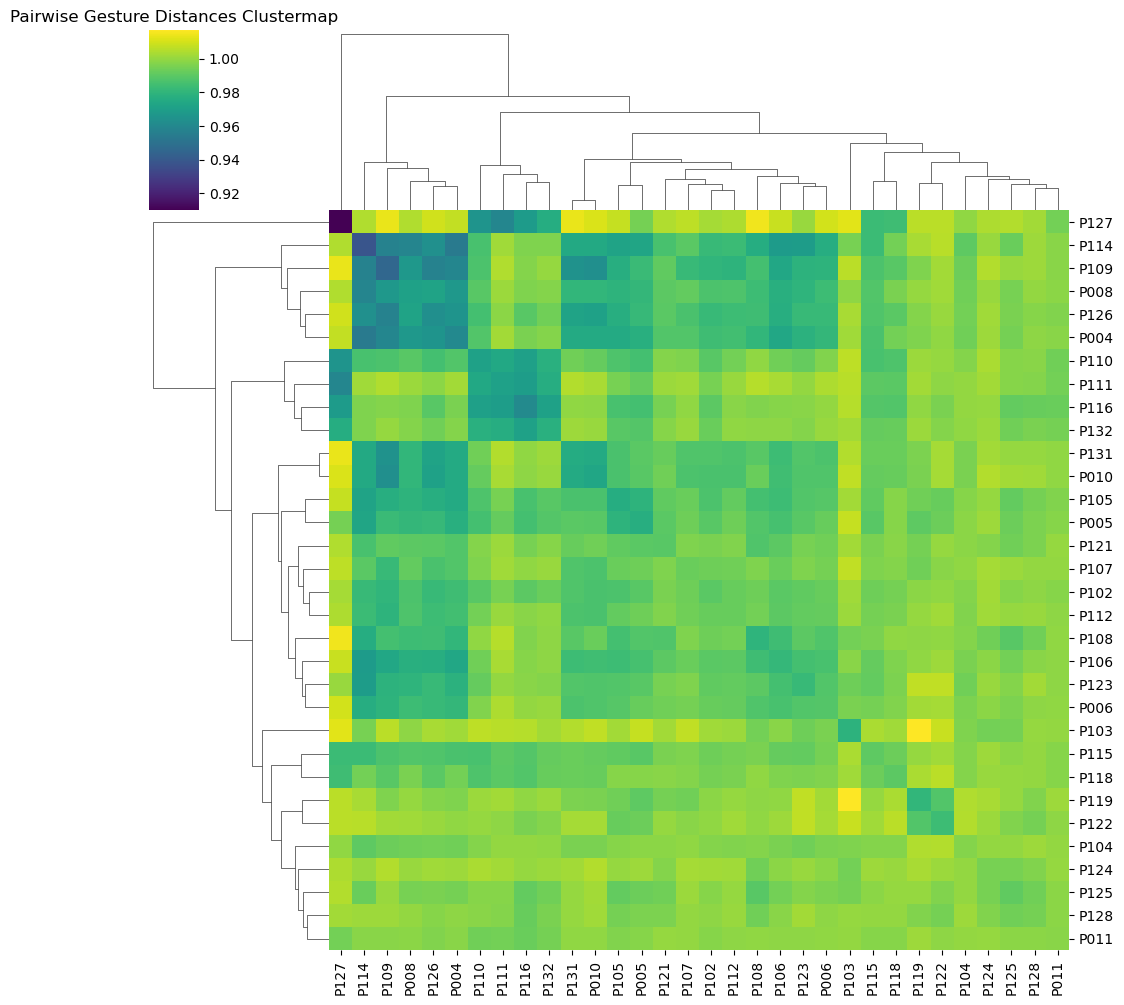

Clustermap completed in 1.5230472087860107s


In [44]:
clsmap_obj2, distance_matrix2 = clustermap_users(users_submatrices, participant_labels, dist_metric='correlation', dist_norm='fro', dist_method='mean')


Distance matrix completed in 0.1016240119934082s


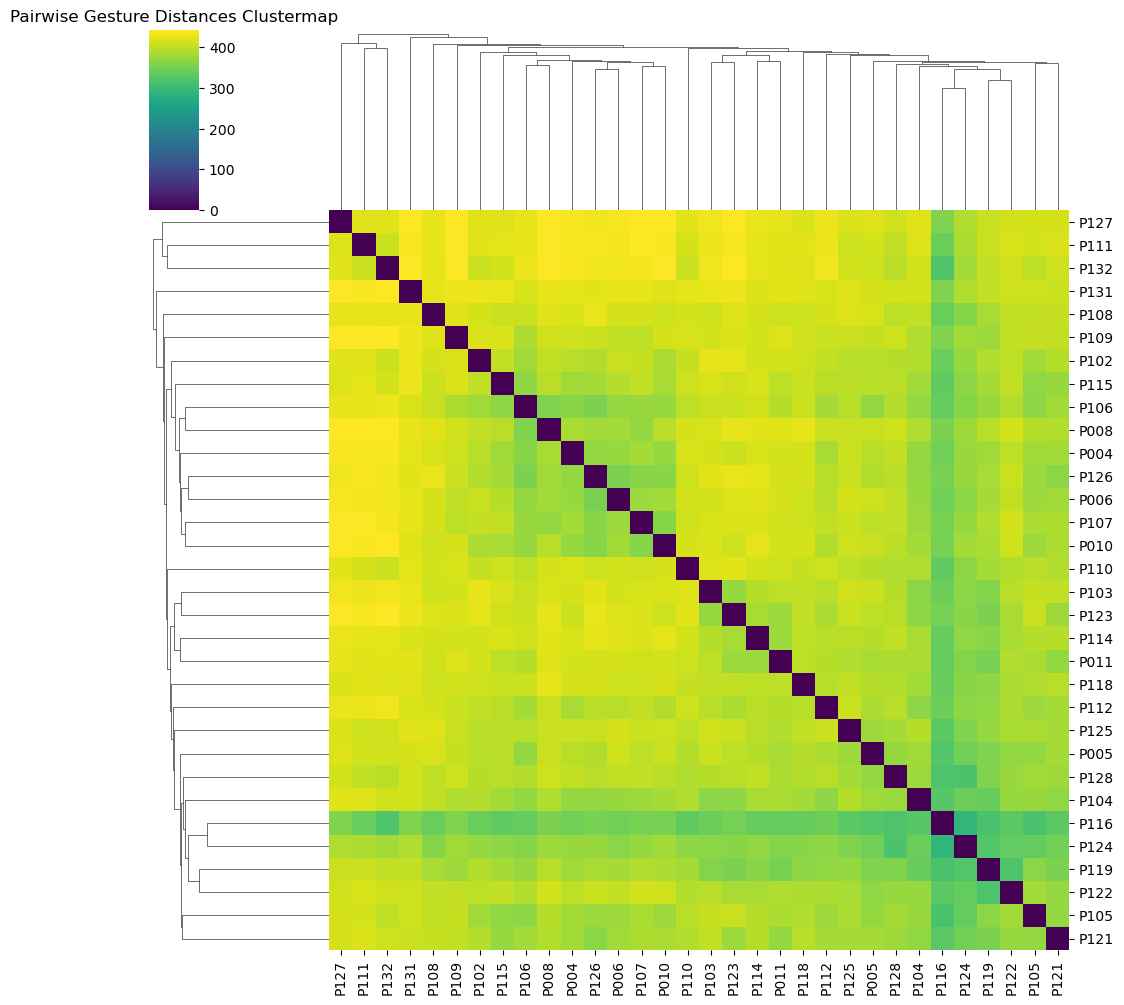

Clustermap completed in 1.4771130084991455s


In [45]:
clsmap_obj3, distance_matrix3 = clustermap_users(users_submatrices, participant_labels, dist_metric=None, dist_norm='fro', dist_method='norm')


Distance matrix completed in 0.08479142189025879s


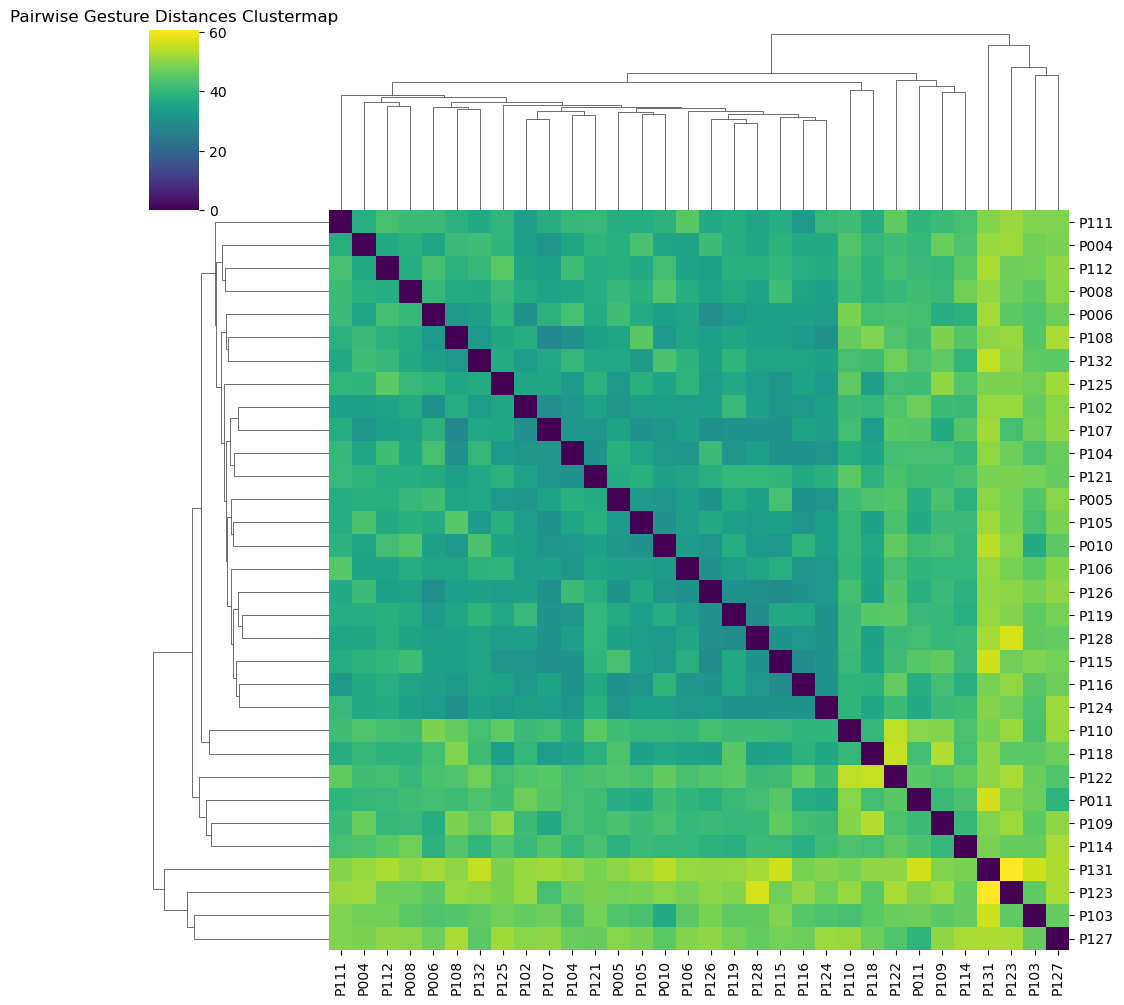

Clustermap completed in 1.4290292263031006s


In [46]:
clsmap_obj4, distance_matrix4 = clustermap_users(users_submatrices, participant_labels, dist_metric=None, dist_norm=np.inf, dist_method='norm')
